# Part I

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score
import random
from PIL import Image

In [2]:
transform_data = transforms.Compose([
    transforms.ToTensor()
])

# transform_imgaug = transforms.Compose([
#     transforms.RandomRotation(degrees=30),
#     transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
# ])

In [3]:
root_path = 'A1Dataset'
dataset = datasets.ImageFolder(root=root_path, transform= transform_data)
#dataset = datasets.ImageFolder(root=root_path)
#dataset

In [4]:
labels = dataset.classes
print(labels)
print(len(labels))

['dogs', 'food', 'vehicles']
3


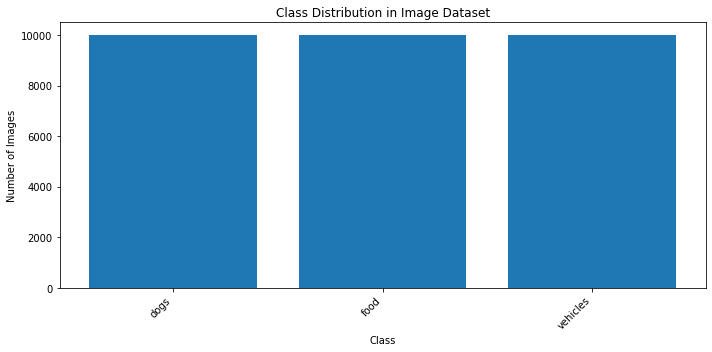

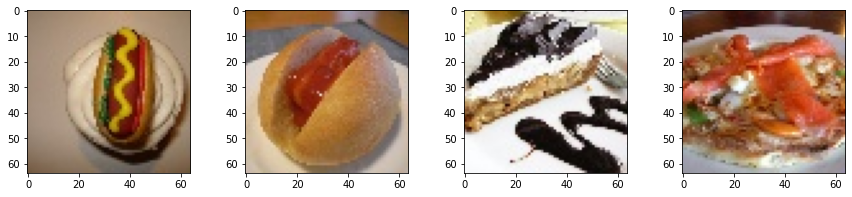

In [5]:
dataset_dir = "A1Dataset"

class_labels = os.listdir(dataset_dir)
class_counts = {label: len(os.listdir(os.path.join(dataset_dir, label))) for label in class_labels}

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Image Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


dataset_dir = "A1Dataset/food"
image_files = os.listdir(dataset_dir)

num_images = 4

fig, axes = plt.subplots(1, num_images, figsize=(15, 3))


for i in range(num_images):
    
    random_image_file = random.choice(image_files)
    image_path = os.path.join(dataset_dir, random_image_file)
    image = Image.open(image_path)
    axes[i].imshow(image)
    #axes[i].axis('off')

plt.show()


In [6]:
BATCH_SIZE = 32
channels = 3
classes = len(labels)
learning_rate = 0.0001

indexes = list(range(len(dataset)))
train_indexes, test_indexes = train_test_split(indexes, test_size=0.3, random_state=42)
test_indexes, val_indexes = train_test_split(test_indexes, test_size=0.5, random_state=42)

train_data = Subset(dataset, train_indexes)

val_data = Subset(dataset, val_indexes)

test_data = Subset(dataset, test_indexes)


train_loader = DataLoader(train_data, batch_size= BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size= BATCH_SIZE, shuffle=False)
validation_loader = DataLoader(val_data, batch_size= BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
print(len(train_loader))
print(len(test_loader))
print(len(validation_loader))

657
141
141


In [8]:
#Neural Net

class VGG13Net(nn.Module):
    def __init__(self, channel, no_of_class):
        super(VGG13Net, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64, 64,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(128, 128,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(128,256, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.conv_layer6 = nn.Sequential(
            nn.Conv2d(256,256,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer7 = nn.Sequential(
            nn.Conv2d(256,512, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.conv_layer8 = nn.Sequential(
            nn.Conv2d(512,512,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer9 = nn.Sequential(
            nn.Conv2d(512,512,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.conv_layer10 = nn.Sequential(
            nn.Conv2d(512,512,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.fc_layer1 = nn.Sequential(
            nn.Linear(512*2*2, 4096),
            nn.ReLU())

        self.fc_layer2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU())

        self.fc_layer3 = nn.Sequential(
            nn.Linear(4096, classes))


    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.conv_layer7(x)
        x = self.conv_layer8(x)
        x = self.conv_layer9(x)
        x = self.conv_layer10(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer1(x)
        x = self.fc_layer2(x)
        x = self.fc_layer3(x)
        return x

model = VGG13Net(channels, classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [9]:
summary(model, input_size=(BATCH_SIZE, channels, 64, 64), device="cuda")

Layer (type:depth-idx)                   Output Shape              Param #
VGG13Net                                 [32, 3]                   --
├─Sequential: 1-1                        [32, 64, 64, 64]          --
│    └─Conv2d: 2-1                       [32, 64, 64, 64]          1,792
│    └─BatchNorm2d: 2-2                  [32, 64, 64, 64]          128
│    └─ReLU: 2-3                         [32, 64, 64, 64]          --
├─Sequential: 1-2                        [32, 64, 32, 32]          --
│    └─Conv2d: 2-4                       [32, 64, 64, 64]          36,928
│    └─BatchNorm2d: 2-5                  [32, 64, 64, 64]          128
│    └─ReLU: 2-6                         [32, 64, 64, 64]          --
│    └─MaxPool2d: 2-7                    [32, 64, 32, 32]          --
├─Sequential: 1-3                        [32, 128, 32, 32]         --
│    └─Conv2d: 2-8                       [32, 128, 32, 32]         73,856
│    └─BatchNorm2d: 2-9                  [32, 128, 32, 32]         256
│

In [10]:
epochs = 6

training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

#Training
for epoch in range(epochs):
    model.train()
    training_loss = 0.0
    correct_training = 0
    total_training = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device) , labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        training_loss += loss.item()

    training_loss /= len(train_loader)
    training_accuracy = 100 * correct_training / total_training
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    #Validation
    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device) , labels.to(device)
            outputs = model(inputs).to(device)
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()

    validation_loss /= len(validation_loader)
    validation_accuracy = 100 * correct_validation / total_validation
    validation_accuracies.append(validation_accuracy)
    validation_losses.append(validation_loss)

    print(f'[{epoch + 1}/{epochs}]- > Training Loss: {training_loss:.2f}, Training Accuracy: {training_accuracy:.2f},Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}')

print('Finished Training')
torch.save(model.state_dict(), 'H5files/rsingh57_ts92_assignment1_part_1.h5')

[1/6]- > Training Loss: 0.61, Training Accuracy: 75.74,Validation Loss: 0.36, Validation Accuracy: 86.11
[2/6]- > Training Loss: 0.33, Training Accuracy: 87.28,Validation Loss: 0.28, Validation Accuracy: 89.62
[3/6]- > Training Loss: 0.27, Training Accuracy: 89.82,Validation Loss: 0.32, Validation Accuracy: 87.73
[4/6]- > Training Loss: 0.22, Training Accuracy: 91.74,Validation Loss: 0.26, Validation Accuracy: 90.33
[5/6]- > Training Loss: 0.19, Training Accuracy: 93.31,Validation Loss: 0.21, Validation Accuracy: 92.07
[6/6]- > Training Loss: 0.14, Training Accuracy: 95.05,Validation Loss: 0.24, Validation Accuracy: 91.29
Finished Training


In [11]:
#Testing

conf_true_labels = []
conf_pred_labels = []

model.eval()
correct_testing = 0
total_testing = 0
testing_loss = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device) , labels.to(device)
        outputs = model(inputs).to(device)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        total_testing += labels.size(0)
        correct_testing += (predicted == labels).sum().item()
        testing_loss += loss.item()

        conf_true_labels.extend(labels.cpu().numpy())
        conf_pred_labels.extend(predicted.cpu().numpy())

testing_loss /= len(validation_loader)
testing_accuracy = 100 * correct_testing / total_testing

print(f'Testing Loss: {testing_loss:.2f} , Testing Accuracy: {testing_accuracy:.2f}')

Testing Loss: 0.25 , Testing Accuracy: 91.51


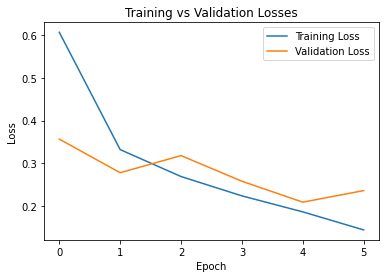

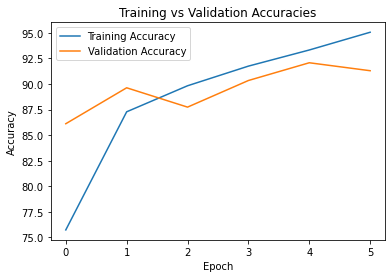

In [12]:
#Training vs Validation loss
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Training vs Validation accuracy
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

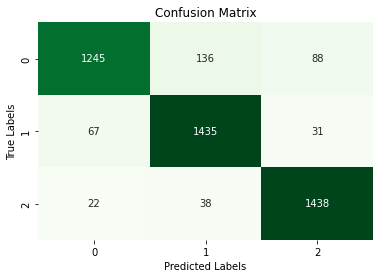

In [13]:
#Confusion Matrix
conf_matrix = confusion_matrix(conf_true_labels, conf_pred_labels)

sns.heatmap(conf_matrix, cbar=False, annot=True, cmap='Greens', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
precision = precision_score(conf_true_labels, conf_pred_labels, average = 'macro')
recall = recall_score(conf_true_labels, conf_pred_labels, average = 'macro')
f1 = f1_score(conf_true_labels, conf_pred_labels, average = 'macro')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Precision: 0.92, Recall: 0.91, F1 Score: 0.91


In [15]:
#L2 Regularization

In [16]:
model = VGG13Net(channels, classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay = 0.0005)

In [17]:
epochs = 6

training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

#Training
for epoch in range(epochs):
    model.train()
    training_loss = 0.0
    correct_training = 0
    total_training = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device) , labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        training_loss += loss.item()

    training_loss /= len(train_loader)
    training_accuracy = 100 * correct_training / total_training
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    #Validation
    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device) , labels.to(device)
            outputs = model(inputs).to(device)
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()

    validation_loss /= len(validation_loader)
    validation_accuracy = 100 * correct_validation / total_validation
    validation_accuracies.append(validation_accuracy)
    validation_losses.append(validation_loss)

    print(f'[{epoch + 1}/{epochs}]- > Training Loss: {training_loss:.2f}, Training Accuracy: {training_accuracy:.2f},Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}')

print('Finished Training')
torch.save(model.state_dict(), 'H5files/rsingh57_ts92_assignment1_part_1_l2.h5')

[1/6]- > Training Loss: 0.60, Training Accuracy: 76.29,Validation Loss: 0.35, Validation Accuracy: 86.27
[2/6]- > Training Loss: 0.33, Training Accuracy: 87.11,Validation Loss: 0.28, Validation Accuracy: 89.89
[3/6]- > Training Loss: 0.28, Training Accuracy: 89.47,Validation Loss: 0.25, Validation Accuracy: 90.53
[4/6]- > Training Loss: 0.23, Training Accuracy: 91.44,Validation Loss: 0.25, Validation Accuracy: 90.98
[5/6]- > Training Loss: 0.19, Training Accuracy: 93.37,Validation Loss: 0.24, Validation Accuracy: 91.40
[6/6]- > Training Loss: 0.15, Training Accuracy: 94.53,Validation Loss: 0.25, Validation Accuracy: 90.53
Finished Training


In [18]:
#Testing

conf_true_labels = []
conf_pred_labels = []

model.eval()
correct_testing = 0
total_testing = 0
testing_loss = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device) , labels.to(device)
        outputs = model(inputs).to(device)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        total_testing += labels.size(0)
        correct_testing += (predicted == labels).sum().item()
        testing_loss += loss.item()

        conf_true_labels.extend(labels.cpu().numpy())
        conf_pred_labels.extend(predicted.cpu().numpy())

testing_loss /= len(validation_loader)
testing_accuracy = 100 * correct_testing / total_testing

print(f'Testing Loss: {testing_loss:.2f} , Testing Accuracy: {testing_accuracy:.2f}')

Testing Loss: 0.27 , Testing Accuracy: 90.02


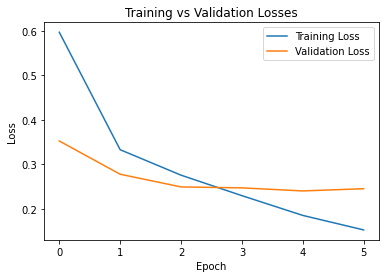

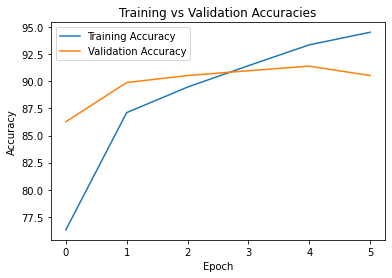

In [19]:
#Training vs Validation loss
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Training vs Validation accuracy
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

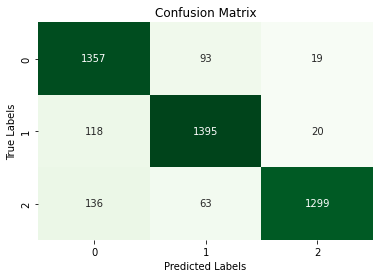

In [20]:
#Confusion Matrix
conf_matrix = confusion_matrix(conf_true_labels, conf_pred_labels)

sns.heatmap(conf_matrix, cbar=False, annot=True, cmap='Greens', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
precision = precision_score(conf_true_labels, conf_pred_labels, average = 'macro')
recall = recall_score(conf_true_labels, conf_pred_labels, average = 'macro')
f1 = f1_score(conf_true_labels, conf_pred_labels, average = 'macro')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Precision: 0.90, Recall: 0.90, F1 Score: 0.90


In [22]:
#L2 + Dropout

In [23]:
#Neural Net

class VGG13Net(nn.Module):
    def __init__(self, channel, no_of_class):
        super(VGG13Net, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64, 64,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(128, 128,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(128,256, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.conv_layer6 = nn.Sequential(
            nn.Conv2d(256,256,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer7 = nn.Sequential(
            nn.Conv2d(256,512, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.conv_layer8 = nn.Sequential(
            nn.Conv2d(512,512,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer9 = nn.Sequential(
            nn.Conv2d(512,512,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.conv_layer10 = nn.Sequential(
            nn.Conv2d(512,512,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.fc_layer1 = nn.Sequential(
            nn.Linear(512*2*2, 4096),
            nn.ReLU(),
            nn.Dropout(0.5))

        self.fc_layer2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5))

        self.fc_layer3 = nn.Sequential(
            nn.Linear(4096, classes))


    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.conv_layer7(x)
        x = self.conv_layer8(x)
        x = self.conv_layer9(x)
        x = self.conv_layer10(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer1(x)
        x = self.fc_layer2(x)
        x = self.fc_layer3(x)
        return x

model = VGG13Net(channels, classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=0.0005)

In [24]:
epochs = 6

training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

#Training
for epoch in range(epochs):
    model.train()
    training_loss = 0.0
    correct_training = 0
    total_training = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device) , labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        training_loss += loss.item()

    training_loss /= len(train_loader)
    training_accuracy = 100 * correct_training / total_training
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    #Validation
    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device) , labels.to(device)
            outputs = model(inputs).to(device)
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()

    validation_loss /= len(validation_loader)
    validation_accuracy = 100 * correct_validation / total_validation
    validation_accuracies.append(validation_accuracy)
    validation_losses.append(validation_loss)

    print(f'[{epoch + 1}/{epochs}]- > Training Loss: {training_loss:.2f}, Training Accuracy: {training_accuracy:.2f},Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}')

print('Finished Training')
torch.save(model.state_dict(), 'H5files/rsingh57_ts92_assignment1_part_1_l2_dropout.h5')

[1/6]- > Training Loss: 0.65, Training Accuracy: 72.88,Validation Loss: 0.39, Validation Accuracy: 84.04
[2/6]- > Training Loss: 0.38, Training Accuracy: 85.10,Validation Loss: 0.32, Validation Accuracy: 87.47
[3/6]- > Training Loss: 0.31, Training Accuracy: 88.28,Validation Loss: 0.32, Validation Accuracy: 87.36
[4/6]- > Training Loss: 0.27, Training Accuracy: 90.01,Validation Loss: 0.24, Validation Accuracy: 90.98
[5/6]- > Training Loss: 0.23, Training Accuracy: 91.48,Validation Loss: 0.36, Validation Accuracy: 87.18
[6/6]- > Training Loss: 0.20, Training Accuracy: 92.60,Validation Loss: 0.23, Validation Accuracy: 91.60
Finished Training


In [25]:
#Testing

conf_true_labels = []
conf_pred_labels = []

model.eval()
correct_testing = 0
total_testing = 0
testing_loss = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device) , labels.to(device)
        outputs = model(inputs).to(device)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        total_testing += labels.size(0)
        correct_testing += (predicted == labels).sum().item()
        testing_loss += loss.item()

        conf_true_labels.extend(labels.cpu().numpy())
        conf_pred_labels.extend(predicted.cpu().numpy())

testing_loss /= len(validation_loader)
testing_accuracy = 100 * correct_testing / total_testing

print(f'Testing Loss: {testing_loss:.2f} , Testing Accuracy: {testing_accuracy:.2f}')

Testing Loss: 0.24 , Testing Accuracy: 90.98


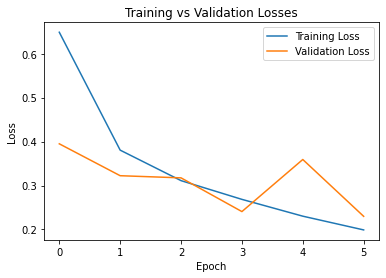

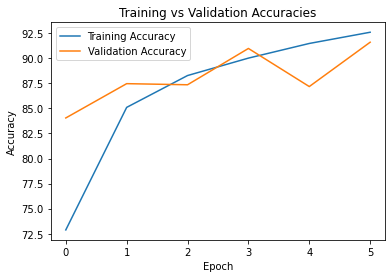

In [26]:
#Training vs Validation loss
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Training vs Validation accuracy
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

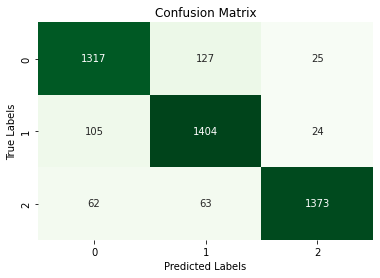

In [27]:
#Confusion Matrix
conf_matrix = confusion_matrix(conf_true_labels, conf_pred_labels)

sns.heatmap(conf_matrix, cbar=False, annot=True, cmap='Greens', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [28]:
precision = precision_score(conf_true_labels, conf_pred_labels, average = 'macro')
recall = recall_score(conf_true_labels, conf_pred_labels, average = 'macro')
f1 = f1_score(conf_true_labels, conf_pred_labels, average = 'macro')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Precision: 0.91, Recall: 0.91, F1 Score: 0.91


In [29]:
#L2 + Dropout + EarlyStopping

In [30]:
#Neural Net

class VGG13Net(nn.Module):
    def __init__(self, channel, no_of_class):
        super(VGG13Net, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64, 64,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(128, 128,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(128,256, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.conv_layer6 = nn.Sequential(
            nn.Conv2d(256,256,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer7 = nn.Sequential(
            nn.Conv2d(256,512, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.conv_layer8 = nn.Sequential(
            nn.Conv2d(512,512,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer9 = nn.Sequential(
            nn.Conv2d(512,512,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.conv_layer10 = nn.Sequential(
            nn.Conv2d(512,512,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.fc_layer1 = nn.Sequential(
            nn.Linear(512*2*2, 4096),
            nn.ReLU(),
            nn.Dropout(0.5))

        self.fc_layer2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5))

        self.fc_layer3 = nn.Sequential(
            nn.Linear(4096, classes))


    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.conv_layer7(x)
        x = self.conv_layer8(x)
        x = self.conv_layer9(x)
        x = self.conv_layer10(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer1(x)
        x = self.fc_layer2(x)
        x = self.fc_layer3(x)
        return x

In [31]:
model = VGG13Net(channels, classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=0.0005)

[1/10]- > Training Loss: 0.64, Training Accuracy: 73.77,Validation Loss: 0.38, Validation Accuracy: 84.84
[2/10]- > Training Loss: 0.37, Training Accuracy: 85.97,Validation Loss: 0.29, Validation Accuracy: 88.71
[3/10]- > Training Loss: 0.31, Training Accuracy: 88.35,Validation Loss: 0.26, Validation Accuracy: 89.80
[4/10]- > Training Loss: 0.26, Training Accuracy: 90.27,Validation Loss: 0.26, Validation Accuracy: 90.09
[5/10]- > Training Loss: 0.23, Training Accuracy: 91.57,Validation Loss: 0.25, Validation Accuracy: 90.67
[6/10]- > Training Loss: 0.19, Training Accuracy: 92.91,Validation Loss: 0.21, Validation Accuracy: 91.93
[7/10]- > Training Loss: 0.16, Training Accuracy: 94.09,Validation Loss: 0.23, Validation Accuracy: 91.47
[8/10]- > Training Loss: 0.14, Training Accuracy: 95.06,Validation Loss: 0.32, Validation Accuracy: 89.51
Early stopping...
Finished Training




Testing Loss: 0.27 , Testing Accuracy: 91.27


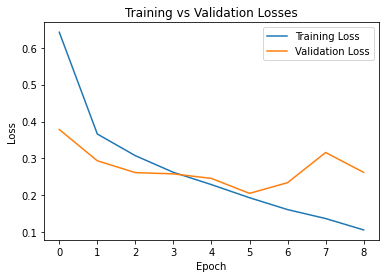

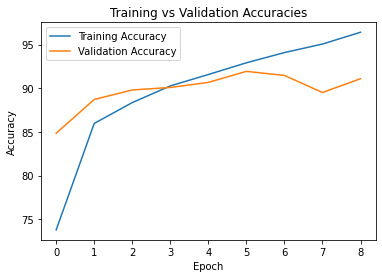

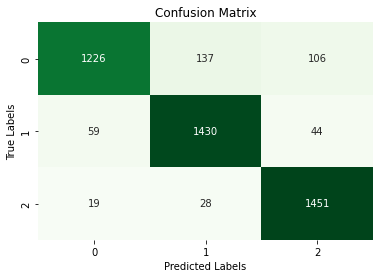

Precision: 0.91, Recall: 0.91, F1 Score: 0.91


In [32]:
epochs = 10

#Early stopping variables
early_counter = 0
patience = 3
early_val_loss = None

training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

#Training
for epoch in range(epochs):
    model.train()
    training_loss = 0.0
    correct_training = 0
    total_training = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device) , labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        training_loss += loss.item()

    training_loss /= len(train_loader)
    training_accuracy = 100 * correct_training / total_training
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    #Validation
    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device) , labels.to(device)
            outputs = model(inputs).to(device)
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()

    validation_loss /= len(validation_loader)
    validation_accuracy = 100 * correct_validation / total_validation
    validation_accuracies.append(validation_accuracy)
    validation_losses.append(validation_loss)
    
    if early_val_loss == None:
        early_val_loss = round(validation_loss, 2)
    elif validation_loss < early_val_loss:
        early_val_loss = round(validation_loss, 2)
        early_counter = 0
        torch.save(model.state_dict(), 'H5files/rsingh57_ts92_assignment1_part_1_l2_dropout_earlystopping.h5')
    else:
        early_counter += 1

    if early_counter >= patience:
        print("Early stopping...")
        break

    print(f'[{epoch + 1}/{epochs}]- > Training Loss: {training_loss:.2f}, Training Accuracy: {training_accuracy:.2f},Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}')

print('Finished Training')
#torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/SUNY/DL/A0/rsingh_57_ts92_assignment1_part_1_base.h5')

#Testing

conf_true_labels = []
conf_pred_labels = []

model.eval()
correct_testing = 0
total_testing = 0
testing_loss = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device) , labels.to(device)
        outputs = model(inputs).to(device)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        total_testing += labels.size(0)
        correct_testing += (predicted == labels).sum().item()
        testing_loss += loss.item()

        conf_true_labels.extend(labels.cpu().numpy())
        conf_pred_labels.extend(predicted.cpu().numpy())

testing_loss /= len(validation_loader)
testing_accuracy = 100 * correct_testing / total_testing

print('\n\n\n')
print(f'Testing Loss: {testing_loss:.2f} , Testing Accuracy: {testing_accuracy:.2f}')

#Training vs Validation loss
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Training vs Validation accuracy
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Confusion Matrix
conf_matrix = confusion_matrix(conf_true_labels, conf_pred_labels)

sns.heatmap(conf_matrix, cbar=False, annot=True, cmap='Greens', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

precision = precision_score(conf_true_labels, conf_pred_labels, average = 'macro')
recall = recall_score(conf_true_labels, conf_pred_labels, average = 'macro')
f1 = f1_score(conf_true_labels, conf_pred_labels, average = 'macro')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

In [40]:
#L2 + Dropout + Early Stopping + Image Augmentation

In [41]:
transform_data = transforms.Compose([
    transforms.ToTensor()
])

transform_imgaug = transforms.Compose([
    transforms.RandomRotation(degrees=35),
    transforms.RandomResizedCrop(size=64, scale=(0.7, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

root_path = 'A1Dataset'
#dataset = datasets.ImageFolder(root=root_path, transform= transform_data)
dataset = datasets.ImageFolder(root=root_path)
#dataset

In [42]:
BATCH_SIZE = 32
channels = 3
classes = len(labels)
learning_rate = 0.0001

indexes = list(range(len(dataset)))
train_indexes, test_indexes = train_test_split(indexes, test_size=0.3, random_state=42)
test_indexes, val_indexes = train_test_split(test_indexes, test_size=0.5, random_state=42)

train_data = Subset(dataset, train_indexes)
train_data.dataset.transform = transform_imgaug

val_data = Subset(dataset, val_indexes)
val_data.dataset.transform = transform_data

test_data = Subset(dataset, test_indexes)
test_data.dataset.transform = transform_data


train_loader = DataLoader(train_data, batch_size= BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size= BATCH_SIZE, shuffle=False)
validation_loader = DataLoader(val_data, batch_size= BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
#Neural Net

class VGG13Net(nn.Module):
    def __init__(self, channel, no_of_class):
        super(VGG13Net, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=64, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64, 64,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(128, 128,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(128,256, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.conv_layer6 = nn.Sequential(
            nn.Conv2d(256,256,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer7 = nn.Sequential(
            nn.Conv2d(256,512, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.conv_layer8 = nn.Sequential(
            nn.Conv2d(512,512,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.conv_layer9 = nn.Sequential(
            nn.Conv2d(512,512,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.conv_layer10 = nn.Sequential(
            nn.Conv2d(512,512,  kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride= 2))

        self.fc_layer1 = nn.Sequential(
            nn.Linear(512*2*2, 4096),
            nn.ReLU(),
            nn.Dropout(0.5))

        self.fc_layer2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5))

        self.fc_layer3 = nn.Sequential(
            nn.Linear(4096, classes))


    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.conv_layer7(x)
        x = self.conv_layer8(x)
        x = self.conv_layer9(x)
        x = self.conv_layer10(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer1(x)
        x = self.fc_layer2(x)
        x = self.fc_layer3(x)
        return x

model = VGG13Net(channels, classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9,weight_decay=0.0005)

In [44]:
epochs = 8

#Early stopping variables
early_counter = 0
patience = 3
early_val_loss = None

training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

#Training
for epoch in range(epochs):
    model.train()
    training_loss = 0.0
    correct_training = 0
    total_training = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device) , labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
        training_loss += loss.item()

    training_loss /= len(train_loader)
    training_accuracy = 100 * correct_training / total_training
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    #Validation
    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device) , labels.to(device)
            outputs = model(inputs).to(device)
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()

    validation_loss /= len(validation_loader)
    validation_accuracy = 100 * correct_validation / total_validation
    validation_accuracies.append(validation_accuracy)
    validation_losses.append(validation_loss)
    
    if early_val_loss == None:
        early_val_loss = round(validation_loss, 2)
    elif validation_loss < early_val_loss:
        early_val_loss = round(validation_loss, 2)
        early_counter = 0
        torch.save(model.state_dict(), 'H5files/rsingh57_ts92_assignment1_part_1_l2_dropout_earlystopping_imgaug.h5')
    else:
        early_counter += 1

    if early_counter >= patience:
        print("Early stopping...")
        break

    print(f'[{epoch + 1}/{epochs}]- > Training Loss: {training_loss:.2f}, Training Accuracy: {training_accuracy:.2f},Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}')

print('Finished Training')
#torch.save(model.state_dict(), 'H5files/rsingh57_ts92_assignment1_part_1_l2_dropout_earlystopping_imgaug.h5')

[1/8]- > Training Loss: 0.71, Training Accuracy: 73.82,Validation Loss: 0.36, Validation Accuracy: 86.31
[2/8]- > Training Loss: 0.35, Training Accuracy: 86.87,Validation Loss: 0.29, Validation Accuracy: 88.96
[3/8]- > Training Loss: 0.29, Training Accuracy: 89.16,Validation Loss: 0.28, Validation Accuracy: 89.58
[4/8]- > Training Loss: 0.26, Training Accuracy: 90.50,Validation Loss: 0.23, Validation Accuracy: 91.67
[5/8]- > Training Loss: 0.22, Training Accuracy: 91.79,Validation Loss: 0.27, Validation Accuracy: 89.80
[6/8]- > Training Loss: 0.19, Training Accuracy: 93.08,Validation Loss: 0.24, Validation Accuracy: 91.29
Early stopping...
Finished Training


In [45]:
#Testing

conf_true_labels = []
conf_pred_labels = []

model.eval()
correct_testing = 0
total_testing = 0
testing_loss = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device) , labels.to(device)
        outputs = model(inputs).to(device)
        labels = labels.squeeze().long()
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        total_testing += labels.size(0)
        correct_testing += (predicted == labels).sum().item()
        testing_loss += loss.item()

        conf_true_labels.extend(labels.cpu().numpy())
        conf_pred_labels.extend(predicted.cpu().numpy())

testing_loss /= len(validation_loader)
testing_accuracy = 100 * correct_testing / total_testing

print(f'Testing Loss: {testing_loss:.2f} , Testing Accuracy: {testing_accuracy:.2f}')

Testing Loss: 0.26 , Testing Accuracy: 91.18


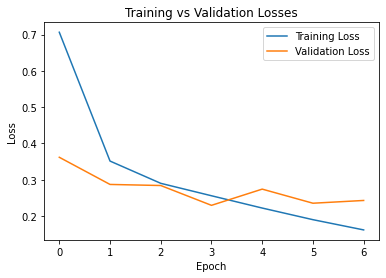

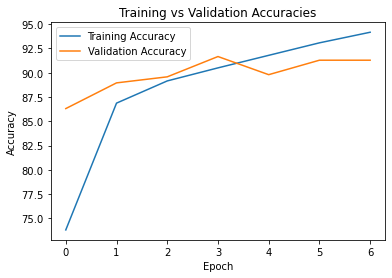

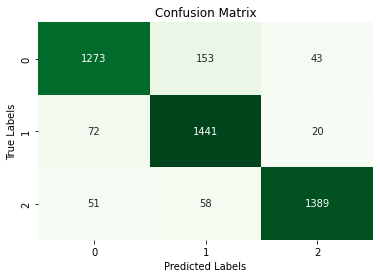

Precision: 0.91, Recall: 0.91, F1 Score: 0.91


In [46]:
#Training vs Validation loss
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Training vs Validation accuracy
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Confusion Matrix
conf_matrix = confusion_matrix(conf_true_labels, conf_pred_labels)

sns.heatmap(conf_matrix, cbar=False, annot=True, cmap='Greens', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

precision = precision_score(conf_true_labels, conf_pred_labels, average = 'macro')
recall = recall_score(conf_true_labels, conf_pred_labels, average = 'macro')
f1 = f1_score(conf_true_labels, conf_pred_labels, average = 'macro')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')